In [16]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# %%writefile runaux.py

import os, sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

Num GPUs Available:  4
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
4 Physical GPUs, 4 Logical GPUs
Collected: (48925, 3)
========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   41.5s finished


Best: -4.092095 using {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
---------------------------------------------------------------------------
-4.126956 (0.019014) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
-4.104494 (0.018606) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
-4.099211 (0.020353) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
-4.094294 (0.019546) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
-4.093266 (0.019840) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
-4.093189 (0.019430) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
-4.092137 (0.019341) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
-4.092973 (0.020055) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
-4.092095 (0.019758) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
-4.092372 (0.019774) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20

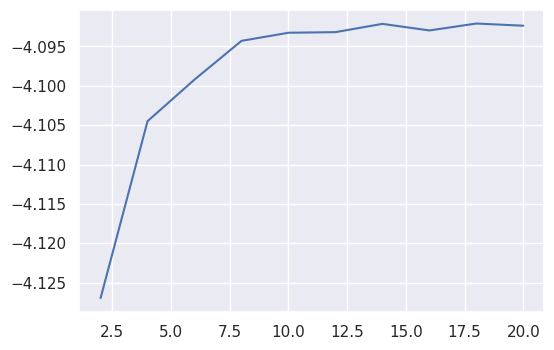

---Likelihoods---
Training: -4.090
CIFAR: -4.093
Outliers: -4.957
========================= Training Flow Model =========================
390/390 [==============================] - 2s 5ms/step - loss: 5951.2227 - val_loss: 917.5837


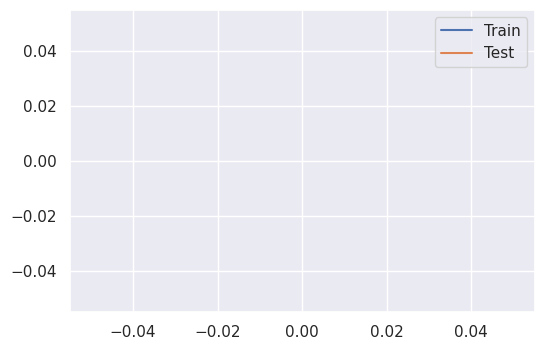

========================= Training KD Tree =========================


In [55]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

LABELS = np.array(["Train", "CIFAR", "Outliers"])
COLORS = sns.color_palette("bright")
results = {}

## Hyperprameter analysis

NUM_Ls = [1, 3, 7, 10, 15, 20]
SIGMAs = [0.5,1,2,10]
# print(sys.argv)
# EXPERIMENT = int(sys.argv[1])
# ID = int(sys.argv[1])

EXPERIMENT=0
ID=11

if EXPERIMENT == 0: # Run NUM_L experiment
    for L in [3]:  #NUM_Ls
        fname = "SH1e+00_L{}.p".format(L)
        with open(fname, "rb") as f:
            score_dict = pickle.load(f)

        train_scores = np.array(score_dict["train"])
        inlier_scores = np.array(score_dict["cifar"])
    #     outlier_scores = [np.array(score_dict["svhn"])]
        outliers = [n for n in list(score_dict.keys()) if n not in ["train", "cifar", "svhn", "gaussian", "uniform" ]]
        outlier_scores = np.concatenate([np.array(score_dict[n] )for n in outliers])

        if L == 1:
            train_scores = train_scores.reshape(-1,1)
            inlier_scores = inlier_scores.reshape(-1,1)
            outlier_scores = outlier_scores.reshape(-1,1)

        print("Collected:", outlier_scores.shape)

        # Train Data = L2-norm(Pixel Scores)
        X_train, X_test =  train_scores.copy(), inlier_scores.copy()
        result_dict = auxiliary_model_analysis(X_train, X_test, [outlier_scores],
                                              LABELS, flow_epochs=1)

        with open("L_models/{}-{}.p".format(L, ID), "wb") as f:
            pickle.dump(result_dict, f)
# else:
#     for SH in SIGMAs:  
#         fname = "SH{:.0e}_L10.p".format(SH)
#         with open(fname, "rb") as f:
#             score_dict = pickle.load(f)

#         train_scores = np.array(score_dict["train"])
#         inlier_scores = np.array(score_dict["cifar"])
#         outliers = [n for n in list(score_dict.keys()) if n not in ["train", "cifar", "svhn", "gaussian", "uniform" ]]
#         outlier_scores = np.concatenate([np.array(score_dict[n] )for n in outliers])
#         print("Collected:", outlier_scores.shape)

#         # Train Data = L2-norm(Pixel Scores)
#         X_train, X_test =  train_scores.copy(), inlier_scores.copy()
#         result_dict = auxiliary_model_analysis(X_train, X_test, [outlier_scores],
#                                               LABELS, flow_epochs=1000)

#         with open("SH_models/{:.0e}-{}.p".format(SH, ID), "wb") as f:
#             pickle.dump(result_dict, f)

In [14]:
%%writefile run.sh

for i in {0..5};
do
    CUDA_VISIBLE_DEVICES=1 python runaux.py 0 $i &
    CUDA_VISIBLE_DEVICES=1 python runaux.py 0 $(expr $i + 1) &
    
    CUDA_VISIBLE_DEVICES=1 python runaux.py 1 $i &
    CUDA_VISIBLE_DEVICES=1 python runaux.py 1 $(expr $i + 1)
done

Overwriting run.sh


Collected: (48925, 10)
========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.9s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.3min finished


Best: 3.577470 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
3.218259 (0.059808) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
3.376122 (0.059141) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
3.437735 (0.056923) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
3.506301 (0.052774) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
3.531902 (0.049827) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
3.545794 (0.047901) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
3.558641 (0.049146) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
3.569403 (0.050034) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
3.572412 (0.048459) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
3.577470 (0.048870) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


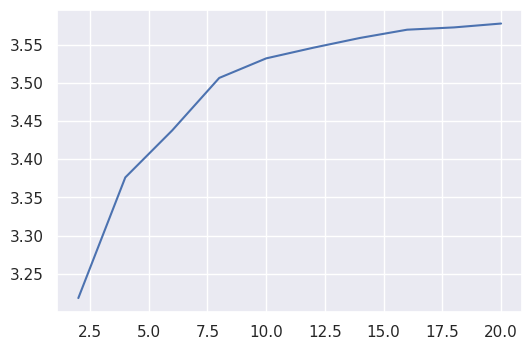

---Likelihoods---
Training: 3.605
CIFAR: 3.334
Outliers: -5.527
========================= Training Flow Model =========================
Epoch 1/1000
390/390 [==============================] - 1s 3ms/step - loss: 27402.9902 - val_loss: 6425.9434
Epoch 2/1000
390/390 [==============================] - 1s 3ms/step - loss: 3520.7271 - val_loss: 1972.0336
Epoch 3/1000
390/390 [==============================] - 1s 3ms/step - loss: 1347.1876 - val_loss: 946.6067
Epoch 4/1000
390/390 [==============================] - 1s 3ms/step - loss: 750.3705 - val_loss: 619.1443
Epoch 5/1000
390/390 [==============================] - 1s 3ms/step - loss: 546.1943 - val_loss: 496.6725
Epoch 6/1000
390/390 [==============================] - 1s 2ms/step - loss: 464.0896 - val_loss: 442.8575
Epoch 7/1000
390/390 [==============================] - 1s 3ms/step - loss: 426.0674 - val_loss: 415.1708
Epoch 8/1000
390/390 [==============================] - 1s 2ms/step - loss: 401.9037 - val_loss: 393.2097
Epoch 9/10

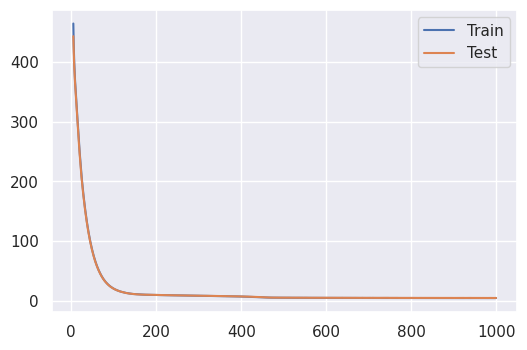

========================= Training KD Tree =========================
Collected: (48925, 10)
========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.5min finished


Best: 2.559941 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
2.245834 (0.058222) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
2.373798 (0.054980) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
2.445346 (0.049269) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
2.488832 (0.048693) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
2.506370 (0.050181) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
2.525569 (0.048946) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
2.533154 (0.049877) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
2.548874 (0.049861) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
2.554960 (0.049454) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
2.559941 (0.045681) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


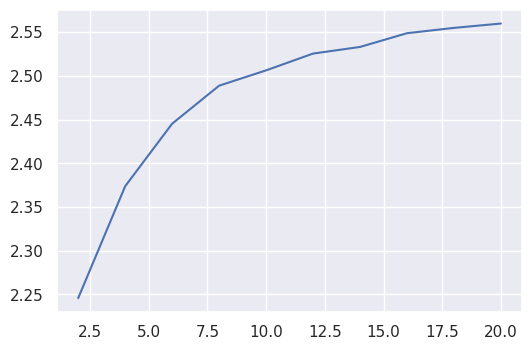

---Likelihoods---
Training: 2.600
CIFAR: 2.471
Outliers: -7.566
========================= Training Flow Model =========================
Epoch 1/1000
390/390 [==============================] - 1s 3ms/step - loss: 1443774.8750 - val_loss: 79909.8047
Epoch 2/1000
390/390 [==============================] - 1s 3ms/step - loss: 27546.1426 - val_loss: 7938.0210
Epoch 3/1000
390/390 [==============================] - 1s 3ms/step - loss: 4115.8486 - val_loss: 2060.7378
Epoch 4/1000
390/390 [==============================] - 1s 2ms/step - loss: 1368.3214 - val_loss: 946.7966
Epoch 5/1000
390/390 [==============================] - 1s 2ms/step - loss: 764.9660 - val_loss: 641.9147
Epoch 6/1000
390/390 [==============================] - 1s 2ms/step - loss: 577.5726 - val_loss: 530.7557
Epoch 7/1000
390/390 [==============================] - 1s 2ms/step - loss: 500.8313 - val_loss: 479.5938
Epoch 8/1000
390/390 [==============================] - 1s 3ms/step - loss: 463.4439 - val_loss: 449.9083
Epoc

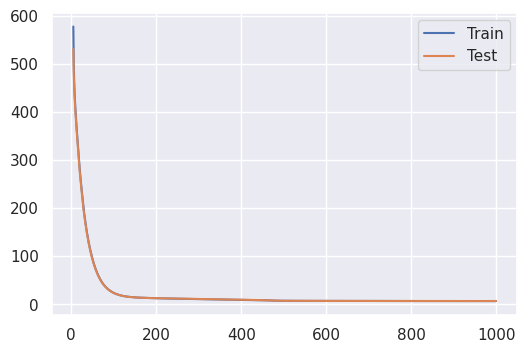

========================= Training KD Tree =========================
Collected: (48925, 10)
========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.5min finished


Best: 0.200402 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
-0.100206 (0.053759) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
0.036176 (0.044680) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
0.090889 (0.043223) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
0.120676 (0.041208) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
0.156259 (0.038394) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
0.170504 (0.036377) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
0.182312 (0.035930) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
0.190265 (0.039385) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
0.193492 (0.037614) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
0.200402 (0.037838) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


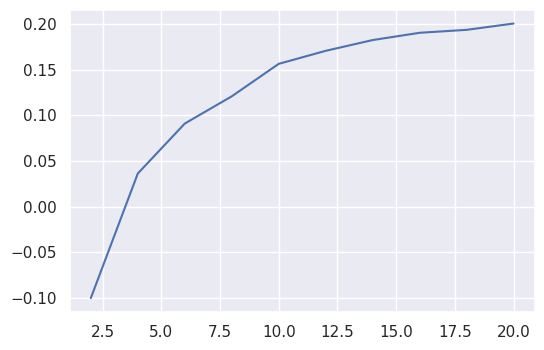

---Likelihoods---
Training: 0.235
CIFAR: 0.143
Outliers: -7.308
========================= Training Flow Model =========================
Epoch 1/1000
390/390 [==============================] - 1s 3ms/step - loss: 3738.3616 - val_loss: 2006.2312
Epoch 2/1000
390/390 [==============================] - 1s 3ms/step - loss: 1514.1886 - val_loss: 1181.9427
Epoch 3/1000
390/390 [==============================] - 1s 3ms/step - loss: 1005.9431 - val_loss: 880.4878
Epoch 4/1000
390/390 [==============================] - 1s 2ms/step - loss: 813.1494 - val_loss: 765.2800
Epoch 5/1000
390/390 [==============================] - 1s 2ms/step - loss: 735.7791 - val_loss: 713.3516
Epoch 6/1000
390/390 [==============================] - 1s 3ms/step - loss: 695.4758 - val_loss: 681.7579
Epoch 7/1000
390/390 [==============================] - 1s 3ms/step - loss: 668.9756 - val_loss: 658.1949
Epoch 8/1000
390/390 [==============================] - 1s 2ms/step - loss: 646.1375 - val_loss: 635.6504
Epoch 9/100

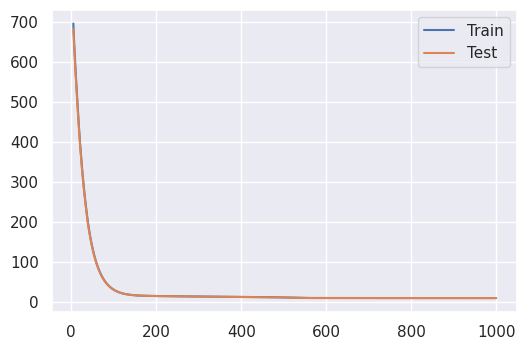

========================= Training KD Tree =========================
Collected: (48925, 10)
========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.6min finished


Best: -5.648269 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
-6.005774 (0.038169) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
-5.875045 (0.042877) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
-5.769342 (0.045358) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
-5.719335 (0.039603) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
-5.699870 (0.042501) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
-5.684631 (0.040641) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
-5.673681 (0.043627) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
-5.659519 (0.044356) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
-5.652222 (0.043457) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
-5.648269 (0.043238) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20

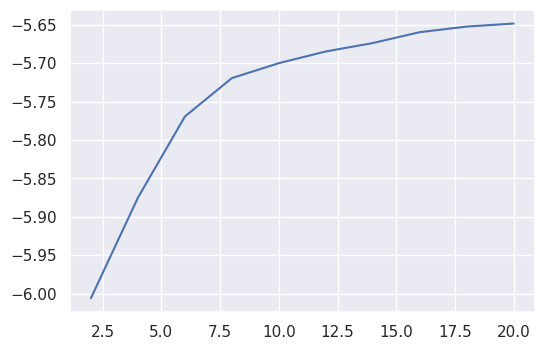

---Likelihoods---
Training: -5.616
CIFAR: -5.677
Outliers: -12.366
========================= Training Flow Model =========================
Epoch 1/1000
390/390 [==============================] - 1s 3ms/step - loss: 6254.4658 - val_loss: 1858.6118
Epoch 2/1000
390/390 [==============================] - 1s 2ms/step - loss: 1065.7225 - val_loss: 620.3738
Epoch 3/1000
390/390 [==============================] - 1s 3ms/step - loss: 454.3133 - val_loss: 340.1406
Epoch 4/1000
390/390 [==============================] - 1s 3ms/step - loss: 279.2084 - val_loss: 234.7779
Epoch 5/1000
390/390 [==============================] - 1s 3ms/step - loss: 210.4882 - val_loss: 192.1673
Epoch 6/1000
390/390 [==============================] - 1s 3ms/step - loss: 181.0901 - val_loss: 172.2623
Epoch 7/1000
390/390 [==============================] - 1s 3ms/step - loss: 165.9295 - val_loss: 160.0426
Epoch 8/1000
390/390 [==============================] - 1s 3ms/step - loss: 153.1474 - val_loss: 149.1056
Epoch 9/10

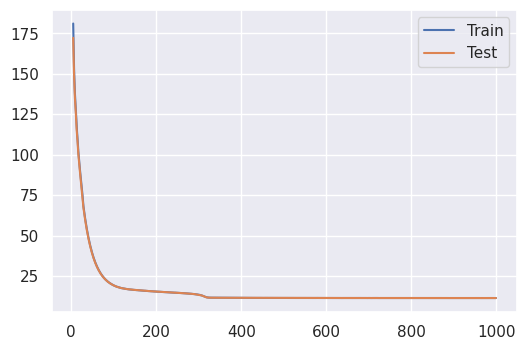

========================= Training KD Tree =========================
CPU times: user 2h 49min 19s, sys: 1h 18min 48s, total: 4h 8min 8s
Wall time: 1h 14min 35s


In [13]:
# %%time
# for SH in SIGMAs:  
#     fname = "SH{:.0e}_L10.p".format(SH)
#     with open(fname, "rb") as f:
#         score_dict = pickle.load(f)

#     train_scores = np.array(score_dict["train"])
#     inlier_scores = np.array(score_dict["cifar"])
#     outliers = [n for n in list(score_dict.keys()) if n not in ["train", "cifar", "svhn", "gaussian", "uniform" ]]
#     outlier_scores = np.concatenate([np.array(score_dict[n] )for n in outliers])
#     print("Collected:", outlier_scores.shape)

#     # Train Data = L2-norm(Pixel Scores)
#     X_train, X_test =  train_scores.copy(), inlier_scores.copy()
#     result_dict = auxiliary_model_analysis(X_train, X_test, [outlier_scores],
#                                           LABELS, flow_epochs=1000)
    
#     with open("SH_models/{:.0e}.p".format(SH), "wb") as f:
#         pickle.dump(result_dict, f)

## Analysis on number of levels (L)

In [11]:
plt.rcParams.update({
    "text.usetex": False,
})

In [116]:
results = {}

for L in NUM_Ls:
    results[L] = {}
    for i in range(11):
        fname = "L_models/{}-{}.p".format(L, i)
        if os.path.exists(fname):
            with open(fname, "rb") as f:
                result_dict=pickle.load(f)
                results[L][i]=result_dict
# _dict = {}
# for L in NUM_Ls:
#     k="L=%d"%L
#     k=L
#     _dict[k] = {}
#     for aux in ["GMM", "Flow", "KD"]:
#         _dict[k][aux] = results[L][aux]["metrics"]["roc_auc"][0]
# df_L = pd.DataFrame(_dict)

rows = []
for L in NUM_Ls:
    for i in results[L]:
        k="L=%d"%L
        k=L
        for aux in ["GMM", "Flow", "KD"]:
            row = [k, aux, results[L][i][aux]["metrics"]["roc_auc"][0]]
            rows.append(row)
            
df_L = pd.DataFrame(rows, columns=["L", "aux", "auc"])

In [117]:
df_L.head()

,L,aux,auc
0,1,GMM,63.712511
1,1,Flow,63.780129
2,1,KD,62.105612
3,1,GMM,63.712511
4,1,Flow,63.780135


(50.0, 100.0)

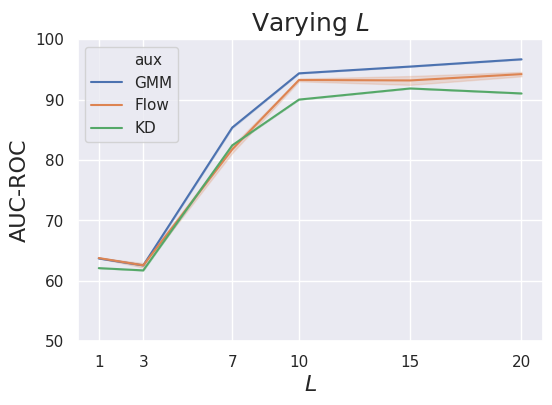

In [118]:
sns.lineplot(x="L", y="auc", data=df_L, hue="aux", ci="sd")
plt.title(r"Varying $L$")
plt.ylabel("AUC-ROC")
plt.xlabel("$L$")
plt.xticks(NUM_Ls)
plt.ylim(50,100)
# plt.savefig("L_analysis.png", dpi=200, bbox_inches='tight')

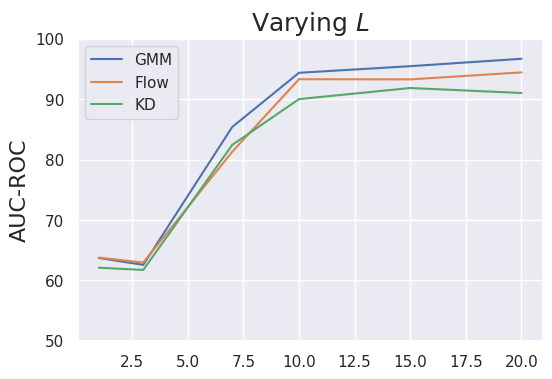

In [33]:
df_L.T.plot(kind="line", rot=0, figsize=(6,4), ylim=(50,100))
plt.title(r"Varying $L$")
plt.ylabel("AUC-ROC")
plt.savefig("L_analysis.png", dpi=200, bbox_inches='tight')

## Analysis on sigma highs (SH)

In [103]:
"SH_models/{:.0e}-{}.p".format(SH, i)

'SH_models/5e-01-1.p'

In [104]:
SIGMAs[0]

0.5

In [119]:
results = {}

for SH in SIGMAs:
    results[SH] = {}
    for i in range(1,4):
        with open("SH_models/{:.0e}-{}.p".format(SH, i), "rb") as f:
            result_dict=pickle.load(f)
            results[SH][i] = result_dict
            
# _dict = {}
# for SH in SIGMAs:
#     k=r"$\sigma_H=%.1f$"%SH
#     k=r"%.1f"%SH
#     _dict[k] = {}
#     for aux in ["GMM", "Flow", "KD"]:
#         _dict[k][aux] = results[SH][aux]["metrics"]["roc_auc"][0]
# df_SH = pd.DataFrame(_dict)

rows = []
for SH in SIGMAs:
    for i in results[SH]:
        k=r"%.1f"%SH
        for aux in ["GMM", "Flow", "KD"]:
            row = [k, aux, results[SH][i][aux]["metrics"]["roc_auc"][0]]
            rows.append(row)
            
df_SH = pd.DataFrame(rows, columns=["SH", "aux", "auc"])

Text(0.5, 0, '$\\sigma_H$')

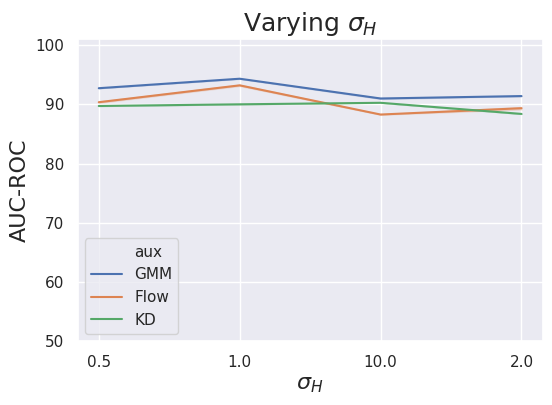

In [120]:
sns.lineplot(x="SH", y="auc", data=df_SH, hue="aux", ci="sd")
plt.ylim(50, 101)
plt.ylabel("AUC-ROC")
plt.title("Varying $\sigma_H$")
plt.xlabel("$\sigma_H$")

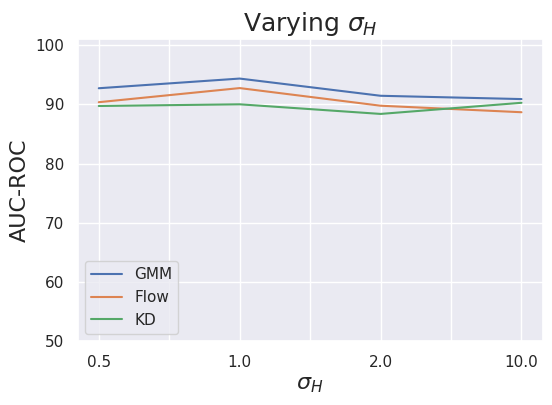

In [84]:
df_SH.T.plot(kind="line", rot=0, figsize=(6,4), ylim=(50, 101))
plt.ylabel("AUC-ROC")
plt.title("Varying $\sigma_H$")
plt.xlabel("$\sigma_H$")
# plt.xticks(SIGMAs)
plt.savefig("sigma_analysis.png", dpi=200, bbox_inches='tight')